# The VLITE Post-Processing Pipeline Users Guide
#### Version 1.5

Last updated: 02/16/2018

This guide demos P3's primary functionality and provides a few examples of how its results can be utilized.

## P3 Walkthrough

This walkthrough will demonstrate how a VLITE image flows through all stages in the Post-Processing Pipeline (P3). The stages and other processing options are specified through a YAML configuration file which is read in by P3.

In [1]:
import sys
sys.path.append('../')
import p3

In [2]:
cf = '/home/erichards/work/p3/demo_config.yaml'
with open(cf, 'r') as f:
    cfg = f.read()
    
print cfg

# p3 configuration file

stages:
                              # processing steps; yes | no  or  True | False
  source finding: yes         # extract sources from image?
  source association: yes     # match extracted sources to existing catalog?
  catalog matching: yes       # cross-match with sky survey catalogs?

options:
                              # processing options; yes | no or True | False
  save to database: yes       # save results to database?
  quality checks: yes         # run image & source count quality checks?
  overwrite: yes              # overwrite database if exists?
  reprocess: no               # redo selected stages even if done previously?
  redo match: no              # redo cross-matching with all sky catalogs?
  update match: no            # update cross-matching with new sky catalogs?

setup:
  root directory: /home/erichards/work/p3/test/
  year: 2540
  month: 06
  day: [3]                    # list of days to process; [] = all
  database name: demo
  da

The configuration file is divided into 5 sections. The 'stages' and 'options' sections control which steps to run in the pipeline and the options that go with those steps. The 'setup' section is where the user specifies the path to the image files, connection parameters for the database, and a list of sky survey catalogs to use for cross-matching. The 'pybdsf_params' section allows the user to specify any non-default `PyBDSF` parameters for source finding, and the 'image_qa_params' section can be used to specify non-default image quality requirements.

### Command line execution

I'll run each stage of P3 separately in this walkthrough to break down the steps, but in practice the pipeline will be run from the command line or as part of a batch processing shell script (see the **Batch processing mode** section below).

In [3]:
%run ../p3.py --help

usage: p3.py [-h] [--ignore_prompt] [--remove_catalog_matches]
             [--remove_source] [--add_catalog]
             config_file

Run the VLITE database Post-Processing Pipline (P3)

positional arguments:
  config_file           the YAML configuration file

optional arguments:
  -h, --help            show this help message and exit
  --ignore_prompt       ignore prompt to verify database removal/creation
  --remove_catalog_matches
                        remove matching results for the specified sky survey
                        catalog(s)
  --remove_source       removes the specified source(s) from the database
                        assoc_source table
  --add_catalog         adds any new sky survey catalogs to a table in the
                        database "skycat" schema


The 'help' documentation for p3.py lists the required and optional command line arguments. A YAML configuration file is required. The other optional arguments execute the database pipeline in a different mode to turn off prompts for batch processing, remove sky catalog matching results, remove sources, or add new sky catalogs to the "skycat" database schema which holds all the sky surveys.

### Stage 0 - Connect to existing or create new database

If the *overwrite* option is `True` or 'yes' and the database exists, all relations in the existing database "public" schema will be deleted and re-created. If the database does not exist, all relations will be created including the "skycat" schema which contains all the sky survey catalogs.

In this example, the database *demo* already exists, but I'm going to overwrite the tables to start fresh. The "skycat" schema with all the radio sky survey catalogs arleady exists, but I'm going to run p3.py with the optional "--add_catalog" argument to make sure the tables are all up to date. Make sure the *overwrite* option in the configuration file is turned off before running this command.

In [4]:
%run ../p3.py ../demo_config.yaml --add_catalog


Connected to database demo.

Using existing database demo.

No new sky catalogs to add.


The "--add_catalog" option calls the function `skycatalog.skycatdb.create()` which cross-checks all the table names in the "skycat" database schema with the list of sky survey catalog names defined in `skycatalog.catalogio.catalog_list`. If there is a catalog in the list which does not yet have a corresponding database table, then that catalog will be read and its sources inserted into a new table of the same name. The "skycat" schema in the *demo* database is up to date, so we can move forward.

In [5]:
stages, opts, setup, sfparams, qaparams, dirs = p3.cfgparse(cf)

In [6]:
conn = p3.dbinit(setup['database name'], setup['database user'], opts['overwrite'], qaparams)


Connected to database demo.

Overwriting existing database tables.


Dropping tables if they exist...

Creating new tables...


You can check out the "skycat" schema part of the database by prepending "skycat." before the table name in all SQL queries. In psql, '\dt skycat.\*' will list all the tables in the "skycat" schema. The **skycat.catalogs** table lists information for all the catalogs contained in the schema.

In [7]:
import psycopg2
import psycopg2.extras
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)

In [8]:
cur = conn.cursor()

In [9]:
cur.execute('SELECT * FROM skycat.catalogs')
catalog_rows = cur.fetchall()
catalog_cols = [desc[0] for desc in cur.description]
catalogdf = pd.DataFrame(catalog_rows, columns=catalog_cols)
catalogdf.set_index('id', inplace=True)
catalogdf

,name,telescope,frequency,resolution
id,,,,
1,cosmos,VLA,320.0,6.0
2,first,VLA,1400.0,5.0
3,gleam,MWA,150.0,100.0
4,gpsr1,VLA,1400.0,5.0
5,gpsr5,VLA,5000.0,4.0
6,nordgc,VLA,330.0,10.0
7,nvss,VLA,1400.0,45.0
8,sevenc,CLFST,151.0,70.0
9,sumss,MOST,843.0,45.0


In [10]:
cur.close()

### Stage 1 - Record image metadata in database

The first thing p3.py does behind the scenes is read in every FITS image under the "year-mo/day/" subdirectory. It does so by initializing an instance of the `database.dbclasses.Image()` class and setting attribute values of each Image object from the FITS file header. It then sorts each of these Image objects on its "mjdtime" attribute, so that the images are processed in time order.

In [11]:
# Start the timer
start_time = p3.datetime.now()

In [12]:
# Alter stages & options so the pipeline stops after stage 1
stages = {'source finding' : False, 'source association' : False, 'catalog matching' : False}
opts = {'save to database' : True, 'quality checks' : True, 'overwrite' : False, 'reprocess' : False, 
        'redo match' : False, 'update match' : False}

In [13]:
p3.process(conn, stages, opts, dirs, setup['catalogs'], sfparams, qaparams)

_____________________________________________________________________________________

Starting /home/erichards/work/p3/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.fits.

**********************
STAGE 1: READING IMAGE
**********************

Performing preliminary image quality checks...
...image passed.

Adding new entry to image table.
_________________________________________________________________________________

Starting /home/erichards/work/p3/test/2540-06/03/Images/6GHz.1331+305.IPln1.fits.

**********************
STAGE 1: READING IMAGE
**********************

Performing preliminary image quality checks...
...image passed.

Adding new entry to image table.
___________________________________________________________________________________

Starting /home/erichards/work/p3/test/2540-06/03/Images/1.5GHz.1331+305.IPln1.fits.

**********************
STAGE 1: READING IMAGE
**********************

Performing preliminary image quality checks...
...image passed.

Adding new entry to

With all stages turned off, but with the *save to database* option set to `True`, the pipeline simply reads all FITS files from the specified directory, runs the pre-source finding quality checks (if that option is set to `True`), and inserts them into the database **image** table.

In [14]:
cur = conn.cursor()

In [15]:
cur.execute('SELECT * FROM image')
image_rows = cur.fetchall()
image_cols = [desc[0] for desc in cur.description]
imgdf = pd.DataFrame(image_rows, columns=image_cols)
imgdf.set_index('id', inplace=True)
imgdf

,filename,imsize,obs_ra,obs_dec,pixel_scale,object,obs_date,map_date,obs_freq,primary_freq,bmaj,bmin,bpa,noise,peak,config,nvis,mjdtime,tau_time,duration,radius,nsrc,rms_box,stage,catalogs_checked,error_id,nearest_problem,separation
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,/home/erichards/work/p3/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.fits,"(1673, 1673)",202.784533,30.509155,12.905294,J1331+30,2017-07-31,2017-08-01,340.85,1.5,52.4380,52.4380,0.0,25.9249,26184.8,C,10749,57965.038947,197.0,197.0,None,None,None,1,None,None,M87,22.8617
2,/home/erichards/work/p3/test/2540-06/03/Images/6GHz.1331+305.IPln1.fits,"(1661, 1661)",202.784533,30.509155,13.004100,1331+305,2017-07-31,2017-08-02,340.85,6.0,53.8932,53.8932,0.0,21.5510,25901.4,C,16180,57965.045868,303.0,419.0,None,None,None,1,None,None,M87,22.8617
3,/home/erichards/work/p3/test/2540-06/03/Images/1.5GHz.1331+305.IPln1.fits,"(1682, 1682)",202.784533,30.509155,12.835750,1331+305,2017-07-31,2017-08-01,340.85,1.5,58.4006,58.4006,0.0,11.1972,26008.4,C,123760,57965.175370,2235.0,68872.0,None,None,None,1,None,None,M87,22.8617


The 'radius', 'nsrc', and 'rms_box' columns are updated after source finding and the 'catalogs_checked' column is updated after catalog matching to keep a record of which sky survey catalogs are checked for cross-matches. These images passed all preliminary quality checks, so their 'error_id' columns remain set to `None`. Image quality is assessed based on header metadata. The following requirements must be met in order for the image to pass all checks:
1. integration time on source (tau_time) must be > 60 seconds
2. image noise must be > 0 and < 1000 mJy/beam
3. the ratio of the beam semi-major axis to the semi-minor axis must be < 4
4. the image pointing center cannot be within 20 degrees of a known bright radio source or problem area on the sky

These requirements represent the default values that P3 uses if none are specified in the 'image_qa_params' section of the configuration file. The **error** table summarizes the quality requirements and will change to reflect the values specified by the user in the configuration file *at the time of creation*. This means that if the requirements change in a subsequent run which uses the existing tables, the new requirements will NOT be reflected in the **error** table. They will be recorded in the **run_config** table, though, and are output at runtime if an image fails to pass one of the checks.

In [16]:
cur.execute('SELECT * FROM error')
rows = cur.fetchall()
colnames = [desc[0] for desc in cur.description]
errdf = pd.DataFrame(rows, columns=colnames)
errdf.set_index('id', inplace=True)
errdf

,reason
id,
1,image missing necessary header keyword(s)
2,integration time on source < 60.0 s
3,image noise < 0 or > 1000.0 mJy/beam
4,beam axis ratio > 4.0
5,image center within 20.0 deg of problem source
6,PyBDSF failed to process
7,zero sources extracted
8,source metric > 10.0


At this point in time, images that do not pass one of the checks will be flagged and given an 'error_id' based on which check they failed, but will continue through the pipeline. This is so we may test the current requirements and adjust them as necessary. In the future, images which fail a check will be aborted.

The 'error_id' column in the **image** table corresponds to a particular 'reason' as described in the **error** table. For testing purposes, the closest problem source and its distance to the image pointing center is also recorded in the 'nearest_problem' and 'separation' columns in the **image** table. The following bright radio sources and sky regions are likely to be imaged poorly by VLITE:
* all planets (plus Pluto) and the Sun
* Cassiopeia A
* Cygnus A
* Taurus A
* Hercules A
* M87 (Virgo A)
* Galactic Center
* the North Celestial Pole (NCP)

In [17]:
print imgdf[['config', 'obs_ra', 'obs_dec', 'object', 'primary_freq', 'noise', 'tau_time']]

   config      obs_ra    obs_dec    object  primary_freq    noise  tau_time
id                                                                         
1   C      202.784533  30.509155  J1331+30  1.5           25.9249  197.0   
2   C      202.784533  30.509155  1331+305  6.0           21.5510  303.0   
3   C      202.784533  30.509155  1331+305  1.5           11.1972  2235.0  


Isolating a handful of columns in the **image** table makes it apparent that these images are looking at the same object, the flux calibrator 1331+305 or 3C286. Two of the images were observed with the same primary frequency of 1.5 GHz and one at 6 GHz. Image 3 has a significantly longer integration time on source ('tau_time') and lower noise than images 1 or 2. Therefore, we expect more point sources to be extracted from image 3 than 1 or 2.

In [18]:
cur.close()

### Stage 2 - Source finding

The 'pybdsf_params' section of the configuration file allows the user to define any `PyBDSF` parameters to be used during source finding. Any parameter that is not specified, with the exception of *rms_box* and *rms_box_bright*, is simply run with its default value as defined by `PyBDSF` (see [the PyBDSF docs](http://www.astron.nl/citt/pybdsm/process_image.html#general-reduction-parameters "PyBDSF process_image") for more details).

In [19]:
print sfparams

{'adaptive_thresh': 10.0, 'scale': 1.0, 'thresh': 'hard', 'mode': 'default', 'adaptive_rms_box': True}


The parameters *scale* and *mode* are not `PyBDSF` parameters, but rather control the size of the circular region within which sources are extracted (see below) and processing mode for source finding, respectively. Currently, there are only two options for the *mode* parameter: 'default' or 'minimize_islands'. 'Default' mode just runs the image through `PyBDSF` in a single pass using the specified parameters and is the mode that should be used when processing multiple images as part of the pipeline. 'Minimize_islands' runs `PyBDSF` on an image multiple times and attempts to minimize the number of islands that it finds by incrementing the *rms_box* size parameter up and down. This is useful when dealing with images that have lots of artifacts and fake sources and a conservative approach is desired. This mode is very time consuming, however, so is only recommended to be used when exploring appropriate `PyBDSF` parameters for a single image.

There is some pre-processing that is done before the image is read into `PyBDSF`. The images are trimmed to a common circular field-of-view which is either 2, 3, or 4 degrees in radius depending on the configuration, unless the *scale* parameter is something other than 1.0. This is done so that the images are no longer shaped irregularly and to ensure that images of the same field in the same configuration cover the exact same area on the sky. Any discrepancy between sources detected in one image vs. another at the same pointing should be entirely due to the image depth and quality.
The *scale* parameter allows the user to trim the image down to a radius that is smaller by the factor specified (i.e. an image with a full size radius of 4 degrees would be trimmed to a circular region of radius 2 degrees if *scale* = 0.5).

Experience has shown that it is better to specify the *rms_box* parameter rather than leave `PyBDSF` to calculate it internally (the default option). Images with bright ray-like or stripe artifacts will fail miserably with the default option. Setting the box size to 1/10th of the image size in pixels and the step size to 1/3rd of the box size seems to help avoid identifying bright non-point-like artifacts as real emission while still capturing most of the real point sources. The *rms_box* parameter is calculated in this way for every image run through P3, unless it is explicitly specified in the configuration file. The *rms_box_bright* parameter is also calculated for every image as 1/5th times the *rms_box* sizes. This parameter is used by `PyBDSF` only if *adaptive_rms_box* is set to `True` in the configuration file. This tells `PyBDSF` to use the smaller box size around bright sources where there tend to be more imaging artifacts. 

In summary, the following `PyBDSF` parameters have been found to yield the best all-around results for a variety of VLITE images and are used for P3:
* *thresh* = 'hard'
* *rms_box* = (1/10 x image size, 1/3 x 1/10 x image size)
* *adaptive_rms_box* = `True`
* *adaptive_thresh* = 10.0
* *rms_box_bright* = 1/5 x (*rms_box*)

In [20]:
# Alter stages & options so the pipeline stops after stage 2
stages = {'source finding' : True, 'source association' : False, 'catalog matching' : False}
opts = {'save to database' : True, 'quality checks' : True, 'overwrite' : False, 'reprocess' : True, 
        'redo match' : False, 'update match' : False}

In [21]:
p3.process(conn, stages, opts, dirs, setup['catalogs'], sfparams, qaparams)

_____________________________________________________________________________________

Starting /home/erichards/work/p3/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.fits.

**********************
STAGE 1: READING IMAGE
**********************

Performing preliminary image quality checks...
...image passed.

Updating existing entries in image table.

Removing previous sources...

**********************
STAGE 2: SOURCE FINDNG
**********************

Extracting sources...
 -- found 36 sources in 6.71 seconds

--> Wrote ds9 region file '/home/erichards/work/p3/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.crop.pybdsm.srl.reg'

Performing source count quality checks...
...image passed.

Adding detected sources to database.
Correcting all flux measurements for primary beam response.


Completed source finding on image
/home/erichards/work/p3/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.fits.


_________________________________________________________________________________

Starting /hom

Since the image filenames already exist in the database **image** table, the *reprocess* option must be set to `True`. Otherwise, the pipeline will see that the images have already been processed in some form and will skip them. This only applies to the source finding stage. When *reprocess* is on, the **image** table entry is updated in case any header metadata has changed, and any sources extracted from the image previously are deleted from the **detected_island** and **detected_source** tables. These changes propagate to any other affected tables, such as the **assoc_source**, **catalog_match**, **corrected_flux**, and **vlite_unique** tables as necessary. Keep in mind that the source association stage is processing order dependent, so there is no guarantee that those results will be the same after re-processing an image even if the source finding results are the same.

A second round of quality checks are performed on the source finding results (again, only if the *quality checks* option is `True`) before they are inserted into the database tables. Images are flagged if `PyBDSF` failed to process it for any reason or if there were 0 sources extracted. We also define a metric developed by E. Polisensky to flag images where the number of detected sources is much larger than what is expected based on source counts from the WENSS survey and the image's noise. As with the preliminary image quality checks, images that fail are currently still processed and recorded for testing purposes. The only exceptions are the images that `PyBDSF` fails on, since there are no sources output in this scenario.

In addition to inserting properties of the extracted sources into the **detected_island** and **detected_source** database tables, the source list for each image is written out as both an ASCII text file and a ds9 regions file. The residual image after subtracting the Gaussian fits is also saved. This image is useful for evaluating the source finding results.

Let's take a look at the source finding results for the deepest image:

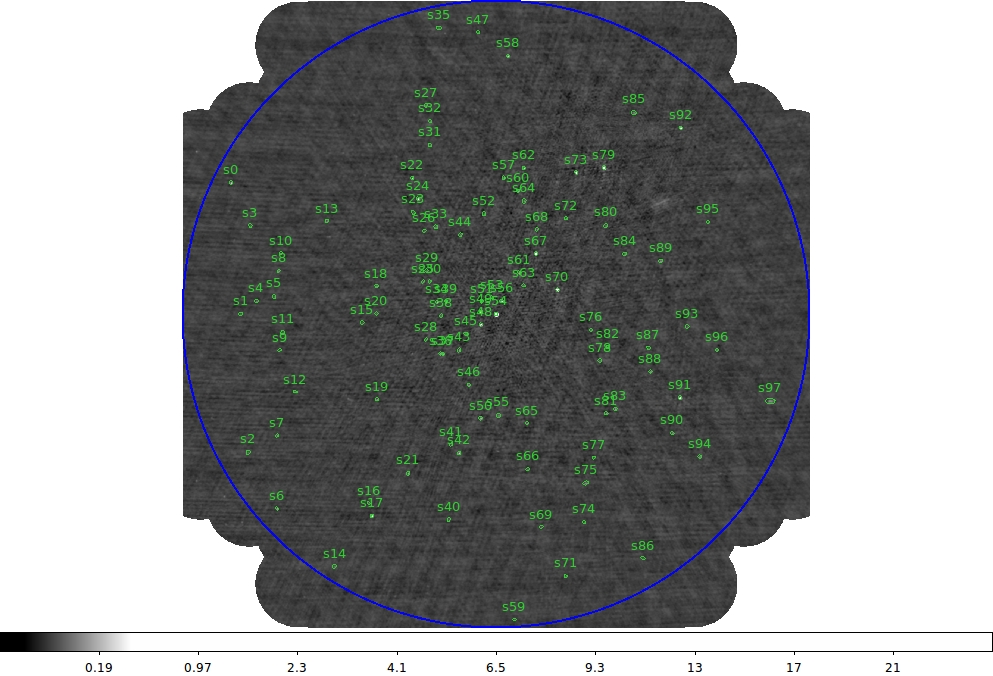

In [22]:
from IPython.display import Image
Image(filename='demo_img1srcs.jpeg')

The blue circle represents where the image was cropped, so only sources within it could be detected.

As expected, there were more sources detected in image 3 (98 vs. 36 & 33). The zoomed-in figure below shows the deepest image in greyscale with its sources outlined in red. The blue and green regions show image 1's and image 2's sources, respectively.

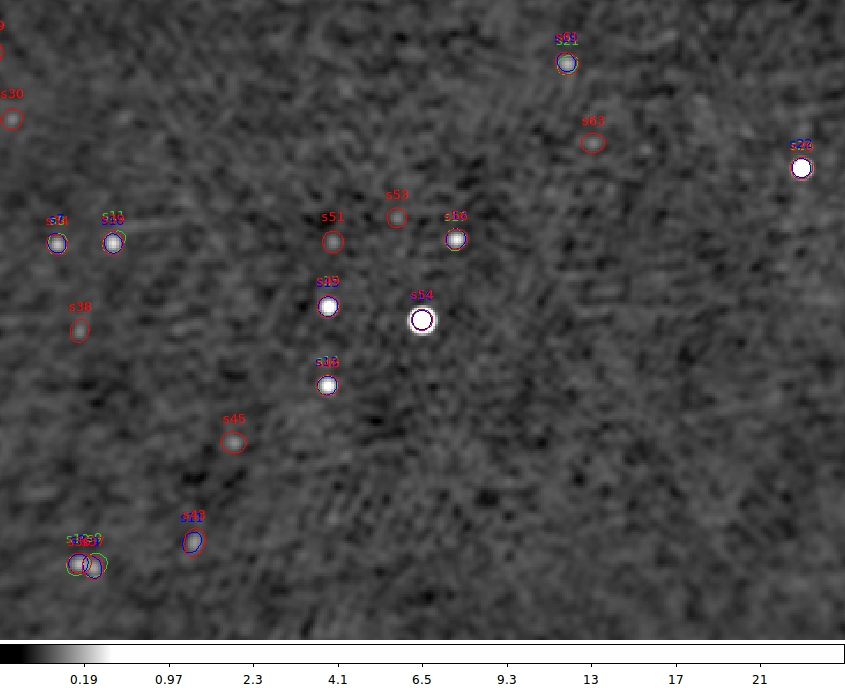

In [23]:
Image(filename='demo_sfcompare.jpeg')

Parameters recorded in the **detected_source** table are roughly the same as what is written out from `PyBDSF`. A description of each column can be found in their [documentation](http://www.astron.nl/citt/pybdsm/write_catalog.html#definition-of-output-columns "definition of output columns").

In [24]:
cur = conn.cursor()

In [25]:
cur.execute('SELECT * FROM detected_source')
dsrows = cur.fetchall()
dscols = [desc[0] for desc in cur.description]
dsdf = pd.DataFrame(dsrows, columns=dscols)
dsdf.head()

,src_id,isl_id,image_id,ra,e_ra,dec,e_dec,total_flux,e_total_flux,peak_flux,e_peak_flux,ra_max,e_ra_max,dec_max,e_dec_max,maj,e_maj,min,e_min,pa,e_pa,dc_maj,e_dc_maj,dc_min,e_dc_min,dc_pa,e_dc_pa,code,assoc_id
0,0,0,1,205.763449,0.000580,31.730901,0.000606,258.752592,35.087510,232.734362,20.942340,205.763449,0.000580,31.730901,0.000606,58.203994,5.487992,52.588824,4.516084,143.309832,39.683321,25.149198,5.487992,3.821616,4.516084,143.309832,39.683321,S,None
1,1,1,1,205.169449,0.000707,28.628060,0.000668,143.774052,32.331335,156.511225,18.135425,205.169449,0.000707,28.628060,0.000668,51.075205,6.008080,49.514994,5.651653,79.202734,157.734567,0.000000,6.008080,0.000000,5.651653,0.000000,157.734567,S,None
2,2,2,1,205.185293,0.000817,29.324438,0.000902,155.331768,34.771234,149.425302,20.325621,205.185293,0.000817,29.324438,0.000902,54.911843,7.665894,52.100559,6.905338,9.810514,108.398843,0.000000,7.665894,0.000000,6.905338,0.000000,108.398843,S,None
3,3,3,1,204.134280,0.000264,28.573072,0.000264,311.061291,32.034512,373.127236,17.363089,204.134280,0.000264,28.573072,0.000264,49.335814,2.370303,46.500620,2.095835,45.878599,33.728004,0.000000,2.370303,0.000000,2.095835,0.000000,33.728004,S,None
4,4,4,1,203.744159,0.001228,28.983080,0.001402,211.628548,38.973378,149.323122,24.874966,203.744159,0.001228,28.983080,0.001402,72.505534,13.677550,53.773564,7.910474,143.118705,26.946271,50.068885,13.677550,11.820631,7.910474,143.118705,26.946271,S,None


The 'radius', 'nsrc', 'rms_box', and 'stage' columns are updated in the **image** table after source finding has been run on the image:

In [26]:
cur.execute('SELECT * FROM image')
newrows = cur.fetchall()
cols = [desc[0] for desc in cur.description]
imgdf = pd.DataFrame(newrows, columns=cols)
imgdf.set_index('id', inplace=True)
imgdf

,filename,imsize,obs_ra,obs_dec,pixel_scale,object,obs_date,map_date,obs_freq,primary_freq,bmaj,bmin,bpa,noise,peak,config,nvis,mjdtime,tau_time,duration,radius,nsrc,rms_box,stage,catalogs_checked,error_id,nearest_problem,separation
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,/home/erichards/work/p3/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.fits,"(1673, 1673)",202.784533,30.509155,12.905294,J1331+30,2017-07-31,2017-08-01,340.85,1.5,52.4380,52.4380,0.0,25.9249,26184.8,C,10749,57965.038947,197.0,197.0,3.0,36,"(167, 56)",2,None,None,M87,22.8617
2,/home/erichards/work/p3/test/2540-06/03/Images/6GHz.1331+305.IPln1.fits,"(1661, 1661)",202.784533,30.509155,13.004100,1331+305,2017-07-31,2017-08-02,340.85,6.0,53.8932,53.8932,0.0,21.5510,25901.4,C,16180,57965.045868,303.0,419.0,3.0,33,"(166, 55)",2,None,None,M87,22.8617
3,/home/erichards/work/p3/test/2540-06/03/Images/1.5GHz.1331+305.IPln1.fits,"(1682, 1682)",202.784533,30.509155,12.835750,1331+305,2017-07-31,2017-08-01,340.85,1.5,58.4006,58.4006,0.0,11.1972,26008.4,C,123760,57965.175370,2235.0,68872.0,3.0,98,"(168, 56)",2,None,None,M87,22.8617


In [27]:
print imgdf[['filename', 'radius', 'nsrc', 'rms_box', 'stage']]

                                                                       filename  \
id                                                                                
1   /home/erichards/work/p3/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.fits   
2   /home/erichards/work/p3/test/2540-06/03/Images/6GHz.1331+305.IPln1.fits       
3   /home/erichards/work/p3/test/2540-06/03/Images/1.5GHz.1331+305.IPln1.fits     

    radius  nsrc    rms_box  stage  
id                                  
1   3.0     36    (167, 56)  2      
2   3.0     33    (166, 55)  2      
3   3.0     98    (168, 56)  2      


The fluxes reported in the **detected_island** and **detected_source** tables are measured fluxes from `PyBDSF` and have not been corrected for the response of the primary beam. Since we do not yet know the true shape of the primary beam for VLITE, corrected fluxes are stored in a different table called **corrected_flux** so that they may be updated easily when the primary beam correction changes. The correction applied currently is a simple 1D model that is a function only of angular distance from the image center.

In [28]:
cur.execute('SELECT * FROM corrected_flux')
cfrows = cur.fetchall()
cfcols = [desc[0] for desc in cur.description]
fluxdf = pd.DataFrame(cfrows, columns=cfcols)
fluxdf.head()

,src_id,isl_id,image_id,total_flux,e_total_flux,peak_flux,e_peak_flux,isl_total_flux,isl_e_total_flux,isl_rms,isl_mean,isl_resid_rms,isl_resid_mean,distance_from_center
0,0,0,1,1481.999072,200.962846,1332.980301,119.946734,1417.045425,162.688883,117.278720,14.085776,8.841972,14.120561,2.827600
1,1,1,1,807.664945,181.624470,879.217269,101.877541,703.667954,120.479691,104.221291,13.712498,5.257486,13.607101,2.800071
2,2,2,1,790.251159,176.898832,760.201986,103.406700,658.388398,120.826661,102.491699,-5.465990,6.992911,-5.418883,2.394382
3,3,3,1,1540.876151,158.686459,1848.326602,86.009959,1428.383834,114.767069,90.629428,24.343823,20.052638,23.074580,2.264306
4,4,4,1,695.366538,128.058257,490.644120,81.733865,633.763315,104.994826,77.882707,-0.470625,5.295979,-0.406016,1.738679


In [29]:
cur.close()

### Stage 3 - Source association

Since all 3 images are of the exact same field, but with varying noise and sensitivity, it is more convenient to associate all the source detections so a spatial query of this sky region doesn't return multiple rows which in reality correspond to the same source detected in 3 different images. In this sense, the source association stage condenses the catalog of all VLITE detected point sources by creating a single weighted average position for every observation of the same source. These results are stored in the database **assoc_source** table.

To perform the association, a cone search is run on the **assoc_source** table to extract sources within the exact same sky area that was used to detect sources in the current image and which come from images with similar spatial resolutions. Currently, images are divided into 4 resolution ranges which roughly correspond to the 4 VLA configurations: 
* resolution <= 15" (A or VLITE B+)
* 15" < resolution <= 35" (B)
* 35" < resolution <= 60" (C)
* resolution > 60" (D)

The resolution of an image is defined by the beam semi-minor axis size so it is less sensitive to elongated beam shapes. The semi-minor axis beam size of the image from which a source is first detected and added to the **assoc_source** table is recorded along with the source to enable resolution matching.

The sources extracted from the **assoc_source** table represent all VLITE sources which were detected previously at a similar resolution in that region of the sky. The detected sources from the current image are positionally cross-matched to the **assoc_source** table sources by measuring separation using the unitless de Ruiter radius which normalizes the separation between two positions by their uncertainties. This method involves defining a maximum separation within which two positions are assumed to be genuinely associated. For VLITE, we adopt r < 6.44 which means that the probability of missing a genuine association is only 1 in 1 billion under the assumptions that the differences between genuinely associated positions are entirely due to measurement uncertainty and that those uncertainties follow a Rayleigh distribution.

If an association is made (de Ruiter radius < 6.44), then a new weighted average position is calculated and the entry is updated in the **assoc_source** table. Detected sources that fail to be associated with existing sources are added to the **assoc_source** table as new sources. The number of detections is also recorded with each **assoc_source** entry.

In [30]:
# Alter stages & options so the pipeline runs only stage 3
stages = {'source finding' : False, 'source association' : True, 'catalog matching' : False}
opts = {'save to database' : True, 'quality checks' : False, 'overwrite' : False, 'reprocess' : False, 
        'redo match' : False, 'update match' : False}

In [31]:
p3.process(conn, stages, opts, dirs, setup['catalogs'], sfparams, qaparams)

_____________________________________________________________________________________

Starting /home/erichards/work/p3/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.fits.

**********************
STAGE 1: READING IMAGE
**********************

Initializing /home/erichards/work/p3/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.fits.

***************************
STAGE 3: SOURCE ASSOCIATION
***************************

Extracted 0 sources from assoc_source table within 3.0 degrees.
 -- number of matches: 0
 -- number of new sources to add: 36


Completed source association for image
/home/erichards/work/p3/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.fits.


_________________________________________________________________________________

Starting /home/erichards/work/p3/test/2540-06/03/Images/6GHz.1331+305.IPln1.fits.

**********************
STAGE 1: READING IMAGE
**********************

Initializing /home/erichards/work/p3/test/2540-06/03/Images/6GHz.1331+305.IPln1.fits.

***********

All 36 sources from image 1 initially populate the **assoc_source** table and are extracted as potential matching candidates for the 33 sources in image 2. Only 28/33 sources from image 2 are successfully associated, which means that 5 new sources are added. Out of the now 41 VLITE sources, 40 are successfully associated with the 98 sources extracted from the deepest image. This results in a final count of 99 VLITE sources. This also tells us that there is only 1 source that was detected in image 1 or 2, but not the deepest image 3.

In [32]:
cur = conn.cursor()

In [33]:
cur.execute('SELECT * FROM assoc_source')
asrows = cur.fetchall()
ascols = [desc[0] for desc in cur.description]
asdf = pd.DataFrame(asrows, columns=ascols)
asdf.set_index('id', inplace=True)
asdf.tail()

,ra,e_ra,dec,e_dec,beam,ndetect,nmatches
id,,,,,,,
99,199.769258,0.001686,29.642482,0.000783,58.400604,1,None
33,200.851609,0.000507,29.360061,0.000414,52.438032,2,None
34,200.760723,0.000105,29.692180,0.000097,52.438032,3,None
35,200.696705,0.000105,32.270021,0.000103,52.438032,3,None
36,200.344297,0.000470,30.144180,0.000442,52.438032,3,None


The detections that created a single **assoc_source** entry can be retrieved from the **detected_source** table using the 'assoc_id' column:

In [34]:
cur.execute('SELECT * FROM detected_source WHERE assoc_id = 36')
detect_rows = cur.fetchall()
detect_cols = [desc[0] for desc in cur.description]
print detect_cols
for row in detect_rows:
    print row
    print

['src_id', 'isl_id', 'image_id', 'ra', 'e_ra', 'dec', 'e_dec', 'total_flux', 'e_total_flux', 'peak_flux', 'e_peak_flux', 'ra_max', 'e_ra_max', 'dec_max', 'e_dec_max', 'maj', 'e_maj', 'min', 'e_min', 'pa', 'e_pa', 'dc_maj', 'e_dc_maj', 'dc_min', 'e_dc_min', 'dc_pa', 'e_dc_pa', 'code', 'assoc_id']
(35, 34, 1, 200.344539181564, 0.00123493185467081, 30.1435314399438, 0.000931012123899495, 221.915296404705, 41.2084189625147, 172.097426522935, 25.6496991604309, 200.344539181564, 0.00123493185467081, 30.1435314399438, 0.000931012123899495, 66.6804351847937, 10.958948714433, 53.211994758781, 7.19208631413529, 111.959739232446, 28.9788119005247, 41.1451717093766, 10.958948714433, 9.03030517694181, 7.19208631413529, 111.959739232446, 28.9788119005247, 'S', 36)

(32, 31, 2, 200.344218275095, 0.000916247046704311, 30.1460286904409, 0.00140412304130534, 127.369207188656, 35.2412450160799, 119.611477447611, 20.6138264372798, 200.344218275095, 0.000916247046704311, 30.1460286904409, 0.001404123041305

The single source that has only 1 detection *not* from the deepest image can be isolated by querying the **detected_source** and **assoc_source** tables for sources not in image 3 and with ndetect = 1:

In [35]:
cur.execute('''SELECT a.src_id, a.image_id, a.assoc_id, b.id, b.ndetect FROM detected_source AS a 
    JOIN assoc_source AS b ON a.assoc_id = b.id WHERE a.image_id != 3 AND b.ndetect = 1''')
rows = cur.fetchall()

In [36]:
colnames = [desc[0] for desc in cur.description]
print colnames
for row in rows:
    print row

['src_id', 'image_id', 'assoc_id', 'id', 'ndetect']
(31, 1, 32, 32, 1)


This tells us that the only single detection that came from an image other than the most sensitive (image 3) was source 31 from image 1. Let's see if there are any sources that were detected twice in images 1 & 2, but not image 3.

In [37]:
cur.execute('''SELECT a.src_id, a.image_id, a.assoc_id, b.id, b.ndetect FROM detected_source AS a 
    JOIN assoc_source AS b ON a.assoc_id = b.id WHERE b.ndetect = 2''')
rows = cur.fetchall()

In [38]:
colnames = [desc[0] for desc in cur.description]
print colnames
for row in rows:
    print row

['src_id', 'image_id', 'assoc_id', 'id', 'ndetect']
(8, 3, 37, 37, 2)
(3, 2, 37, 37, 2)
(21, 3, 5, 5, 2)
(4, 1, 5, 5, 2)
(27, 3, 38, 38, 2)
(7, 2, 38, 38, 2)
(43, 3, 12, 12, 2)
(11, 1, 12, 12, 2)
(57, 3, 39, 39, 2)
(18, 2, 39, 39, 2)
(60, 3, 40, 40, 2)
(20, 2, 40, 40, 2)
(71, 3, 24, 24, 2)
(23, 1, 24, 24, 2)
(80, 3, 41, 41, 2)
(27, 2, 41, 41, 2)
(84, 3, 28, 28, 2)
(27, 1, 28, 28, 2)
(85, 3, 29, 29, 2)
(28, 1, 29, 29, 2)
(89, 3, 31, 31, 2)
(30, 1, 31, 31, 2)
(90, 3, 33, 33, 2)
(32, 1, 33, 33, 2)


Filter out sources where one of the 2 detections was from the deepest image, image 3:

In [39]:
# index 2 = 'assoc_id'; index 1 = 'image_id'
rowdict = {}
for row in rows:
    if not row[2] in rowdict:
        rowdict[row[2]] = [row[1]]
    else:
        rowdict[row[2]].append(row[1])
print rowdict

{33: [3, 1], 37: [3, 2], 38: [3, 2], 39: [3, 2], 40: [3, 2], 41: [3, 2], 12: [3, 1], 24: [3, 1], 31: [3, 1], 28: [3, 1], 29: [3, 1], 5: [3, 1]}


In [40]:
print([key for key, value in rowdict.items() if 3 not in value])

[]


In [41]:
cur.close()

All of the sources with 2 detections were detected in image 3, which implies there is a greater likelihood that they are real sources. It will be easier to judge after catalog matching.

At this point, the single detection source from image 1 could either be a missed true association with a source that was also detected in image 3, an imaging artifact, or a transient candidate. Cross-matching with other radio surveys will help sort out the latter two options, but we can rule out the first possibility by computing the minimum separation found between that source and image 3's sources.

In [42]:
from matching import matchfuncs
from database import dbclasses

In [43]:
cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)

In [44]:
cur.execute('SELECT * FROM detected_source WHERE src_id = 31 AND image_id = 1')
im1row = cur.fetchone()
cur.execute('SELECT * FROM detected_source WHERE image_id = 3')
im3rows = cur.fetchall()

In [45]:
# translate row dictionaries to DetectedSource objects
im1src = dbclasses.DetectedSource()
dbclasses.dict2attr(im1src, im1row)
    
im3srcs = []
for im3src in im3rows:
    im3srcs.append(dbclasses.DetectedSource())
    dbclasses.dict2attr(im3srcs[-1], im3src)

In [46]:
# make sure attributes are set
print im1src.ra
print im3srcs[0].ra

200.907245046
205.762188165


In [47]:
cur.execute('SELECT bmin FROM image WHERE id = 1')
bmin = cur.fetchone()[0]
bmin

52.438

In [48]:
match, im3src, min_der = matchfuncs.deRuitermatch(im1src, im3srcs, bmin)
print im1src.src_id, match, im3src.src_id, min_der

31 False 95 207.208968866


The closest source in the most sensitive image (src_id = 95) is separated from the single detection source in image 1 by a de Ruiter radius > 200. This means that it is most likely not a missed association. After inspection, it's not obvious if the source is an artifact or a faint extended source. If there are no sky survey matches found for it, then it's most likely a fake source.

In [49]:
cur.close()

### Stage 4 - Sky catalog cross-matching

All VLITE detected sources are cross-matched with previous radio sky surveys to help isolate transient candidates or fake sources and better characterize the radio sky. Each entry in the **assoc_source** table is cross-matched against sky catalog sources once and the number of different sky catalog matches is recorded in the 'nmatches' column of the **assoc_source** table. The pipeline will only attempt to cross-match a source from the **assoc_source** table if 'nmatches' is 0 or None, or if one of the configuration options *redo match* or *update match* is `True`. *Redo match* will wipe clean any previously existing catalog matching results for entries in the **assoc_source** table that correspond to sources detected in the current image (i.e. newly added rows or rows that were updated after successful association) and then redo cross-matching with all specified sky catalogs. *Update match* will update the sky catalog cross-matching results for all entries in the **assoc_source** table that correspond to sources detected in the current image for which there are no currently existing results for a particular catalog. A list of the sky catalogs which have been checked is recorded in the **image** table.

Sky survey catalogs are stored in tables in a separate schema within the same database. Sources from each of the catalogs are extracted in a cone search over the same sky area as encompassed by the current image. The cross-matching method is the same as for associating sources using the de Ruiter radius. No filtering is done on resolution.

In [50]:
# Alter stages & options so the pipeline runs only stage 4
stages = {'source finding' : False, 'source association' : False, 'catalog matching' : True}
opts = {'save to database' : True, 'quality checks' : False, 'overwrite' : False, 'reprocess' : False, 
        'redo match' : False, 'update match' : False}

In [51]:
p3.process(conn, stages, opts, dirs, setup['catalogs'], sfparams, qaparams)

_____________________________________________________________________________________

Starting /home/erichards/work/p3/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.fits.

**********************
STAGE 1: READING IMAGE
**********************

Initializing /home/erichards/work/p3/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.fits.

*********************************
STAGE 4: MATCHING TO SKY CATALOGS
*********************************

Extracted 1988 sources from first within 3.0 degrees.
Attempting to match 36 sources from this image to 1988 sources from the first sky catalog...
 -- number of matches: 31
 -- number of unmatched VLITE sources: 5

Extracted 1525 sources from nvss within 3.0 degrees.
Attempting to match 36 sources from this image to 1525 sources from the nvss sky catalog...
 -- number of matches: 36
 -- number of unmatched VLITE sources: 0

Extracted 52 sources from sevenc within 3.0 degrees.
Attempting to match 36 sources from this image to 52 sources from the sevenc sky 

When running the sky catalog cross-matching stage in isolation, the image's sources are first extracted from the **detected_source** table. Then, all sources in the **assoc_source** table which were detected in the image are extracted based on the **detected_source** 'assoc_id' values. Sources from the **assoc_source** table with 'nmatches' = 0 or None are carried forward to the sky catalog cross-matching. This effectively means that only the "new" or unassociated VLITE sources detected in each image are cross-matched with the catalog sources.

All successful matches to a sky catalog source are recorded in the **catalog_match** table. The VLITE sources with no sky catalog counterpoint ('nmatches' = 0) are added to the **vlite_unique** table. This table keeps track of the source's id in the **assoc_source** table and **image** table and whether or not the source was detected in that image. When an image's source is added to the **vlite_unique** table, a cone search query is sent to the **image** table to find all previously processed images with similar resolution which contained the source but without it being detected. An entry is added to the **vlite_unique** table for each of these images with the 'detected' column set to `False`. In addition, each time a source in the **assoc_source** table with 'nmatches' = 0 gets pulled for association but is not detected in the current image, a new entry is added to the **vlite_unique** table to record the non-detection in that current image.

In [52]:
cur = conn.cursor()

In [53]:
cur.execute('SELECT * FROM assoc_source LIMIT 1')
arow = cur.fetchone()
print arow

(1, 205.762347118505, 0.000173024882028586, 31.7305262805262, 0.00018829525213267, 52.438032, 3, 5)


In [54]:
cur.execute('SELECT * FROM catalog_match WHERE assoc_id = 1')
crows = cur.fetchall()

In [55]:
colnames = [desc[0] for desc in cur.description]
print colnames
for row in crows:
    print row

['id', 'catalog_id', 'src_id', 'assoc_id', 'min_deruiter']
(32, 7, 1013520, 1, 2.36534274021518)
(68, 8, 29985, 1, 1.73575362966746)
(78, 10, 403731, 1, 1.30982879700915)
(114, 11, 51105, 1, 2.61758894732104)
(134, 13, 124274, 1, 1.54179652550406)


The *catalogs* table in the "skycat" schema can be used to look up which survey corresponds to a particular 'catalog_id'. The catalog matches to this source came from 'catalog_ids' 7, 8, 10, 11, and 13 or NVSS, 7C, TGSS, TXS, and WENSS.

In [56]:
cur.execute('SELECT * FROM skycat.nvss WHERE id = 32')
catrow = cur.fetchone()

In [57]:
colnames = [desc[0] for desc in cur.description]
print colnames
print catrow

['id', 'name', 'ra', 'e_ra', 'dec', 'e_dec', 'total_flux', 'e_total_flux', 'peak_flux', 'e_peak_flux', 'maj', 'e_maj', 'min', 'e_min', 'pa', 'e_pa', 'rms', 'field', 'catalog_id']
(32, 'NVSS_32', 0.00691667, 0.00183333, 15.8818, 0.00197222, 3.5, 0.5, None, None, 87.0, None, 48.6, None, 0.0, None, None, 'C0000P16', 7)


There were no VLITE sources that did not have at least one match to a sky survey source, so the **vlite_unique** table remains empty.

In [58]:
cur.execute('SELECT * FROM assoc_source WHERE nmatches = 0')
print cur.fetchall()
cur.execute('SELECT * FROM vlite_unique')
print cur.fetchall()

[]
[]


### Summary of P3 run

Information about each run of the database pipeline is recorded in the **run_config** table.

In [59]:
nimages, exec_time = p3.print_run_stats(start_time)

--------------------------------------

Run statistics:

Processed 12 images.

Total runtime: 0:02:14.382931



In [60]:
p3.dbio.record_config(conn, cf, start_time, exec_time, nimages, stages, opts, setup, sfparams, qaparams)

In [61]:
cur.execute('SELECT * FROM run_config')
cfgrows = cur.fetchall()
cfgcols = [desc[0] for desc in cur.description]
cfgdf = pd.DataFrame(cfgrows, columns=cfgcols)
cfgdf.set_index('id', inplace=True)
cfgdf

,file,start_time,execution_time,nimages,stages,options,setup,pybdsf_params,image_qa_params
id,,,,,,,,,
1,/home/erichards/work/p3/demo_config.yaml,2018-02-16 13:46:17,00:02:14.400000,12,"{u'source finding': False, u'source association': False, u'catalog matching': True}","{u'quality checks': False, u'reprocess': False, u'update match': False, u'redo match': False, u'save to database': True, u'overwrite': False}","{u'database name': u'demo', u'catalogs': [u'FIRST', u'NVSS', u'SEVENC', u'TGSS', u'TXS', u'WENSS'], u'database user': u'erichards', u'root directory': u'/home/erichards/work/p3/test/', u'month': 6, u'year': 2540, u'day': [3]}","{u'adaptive_thresh': 10.0, u'scale': 1.0, u'thresh': u'hard', u'mode': u'default', u'adaptive_rms_box': True}","{u'max noise (mJy/beam)': 1000.0, u'max source metric': 10.0, u'max beam axis ratio': 4.0, u'min problem source separation (deg)': 20.0, u'min time on source (s)': 60.0}"


The 'nimages' column counts how many times an Image object was initialized for processing, which is why it is 12 in this example (3 images initialized 4 times). This number will be correct when the script is executed as a pipeline. The 'stages', 'options', 'setup', 'pybdsf_params', and 'image_qa_params' columns store the contents of the configuration file as JSON key-value pairs.

In [62]:
cur.close()

### Extended features

#### Removing a sky catalog & it's matching results

It's possible to remove all cross-matching results pertaining to a specified sky catalog by running p3.py with the optional command line argument '--remove_catalog_matches'. Make sure that *overwrite* is set to `False` or 'no' in the configuration file before using this argument.

In [63]:
# Make sure overwrite is set to False in the configuration file before running this command
%run ../p3.py ../demo_config.yaml --remove_catalog_matches


Connected to database demo.

Using existing database demo.

For which catalogs would you like to remove matching results? (List catalogs separated by a comma.)
SEVENC, TXS

Removing matching results for SEVENC, TXS...


In [64]:
cur = conn.cursor()

In [65]:
cur.execute('SELECT catalogs_checked FROM image')
catalogs_checked = cur.fetchall()

In [66]:
# Check that FIRST & NVSS have been removed from the list of catalogs_checked
for row in catalogs_checked:
    print row

([u'first', u'nvss', u'tgss', u'wenss'],)
([u'first', u'nvss', u'tgss', u'wenss'],)
([u'first', u'nvss', u'tgss', u'wenss'],)


In [67]:
cur.execute('''SELECT * FROM catalog_match WHERE catalog_id IN (
        SELECT id FROM skycat.catalogs WHERE name IN ('sevenc', 'txs'))''')
print cur.fetchall()

[]


In [68]:
cur.close()

All matching results in the **catalog_match** table have been removed for the 7C and TXS catalogs and the 'nmatches' column in the **assoc_source** table is updated accordingly.

#### Adding a new sky survey catalog

Adding another sky survey catalog without re-doing the matching for all other catalogs can be accomplished with the *update match* option in the configuration file:

In [69]:
stages = {'source finding' : False, 'source association' : False, 'catalog matching' : True}
opts = {'save to database' : True, 'quality checks' : False, 'overwrite' : False, 'reprocess' : False, 
        'redo match' : False, 'update match' : True}
setup['catalogs'] = ['FIRST', 'NVSS', 'SEVENC', 'TGSS', 'TXS', 'WENSS', 'VLSSr']

In this example, I'll add back in the 7C and TXS catalogs and add a new catalog, VLSSr. The new catalog can simply be added to the complete list of catalogs, or you could change the list so that only the new catalogs are given. The pipeline looks at the list of 'catalogs_checked' in the **image** table and will ignore any catalogs that are already in that list before cross-matching.

In [70]:
p3.process(conn, stages, opts, dirs, setup['catalogs'], sfparams, qaparams)

_____________________________________________________________________________________

Starting /home/erichards/work/p3/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.fits.

**********************
STAGE 1: READING IMAGE
**********************

Initializing /home/erichards/work/p3/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.fits.

*********************************
STAGE 4: MATCHING TO SKY CATALOGS
*********************************

Extracted 52 sources from sevenc within 3.0 degrees.
Attempting to match 36 sources from this image to 52 sources from the sevenc sky catalog...
 -- number of matches: 10
 -- number of unmatched VLITE sources: 26

Extracted 62 sources from txs within 3.0 degrees.
Attempting to match 36 sources from this image to 62 sources from the txs sky catalog...
 -- number of matches: 20
 -- number of unmatched VLITE sources: 16

Extracted 87 sources from vlssr within 3.0 degrees.
Attempting to match 36 sources from this image to 87 sources from the vlssr sky catalog.

When updating the catalog matching results in this way, all sources from an image are initially extracted from the **assoc_source** table, but each source is first checked to see if it already has match results for the particular catalog in the **catalog_match** table before proceeding. This is why the number of matches and number of unmatched VLITE sources vary for each catalog and don't always add up to the total number of sources detected in the image.

In [74]:
conn.close()

## Batch processing mode

The configuration file is set up to run a month's worth of VLITE data at a time. To run multiple months, the pipeline must be run in a batch processing mode. I'll demonstrate this below by adding in the A, B, and D configuration images of this flux calibrator field. Each month will have its own configuration file when batch processing. In this example, I'll be using a separate configuration file for each day rather than month to demonstrate the process.

In [75]:
cf = '/home/erichards/work/p3/3c286A_config.yaml'
with open(cf, 'r') as f:
    cfg = f.read()
    
print cfg

# p3 configuration file

stages:
                              # processing steps; yes | no  or  True | False
  source finding: yes         # extract sources from image?
  source association: yes     # match extracted sources to existing catalog?
  catalog matching: yes       # cross-match with sky survey catalogs?

options:
                              # processing options; yes | no or True | False
  save to database: yes       # save results to database?
  quality checks: yes         # run image & source count quality checks?
  overwrite: no               # overwrite database if exists?
  reprocess: no               # redo selected stages even if done previously?
  redo match: no              # redo cross-matching with all sky catalogs?
  update match: no            # update cross-matching with new sky catalogs?

setup:
  root directory: /home/erichards/work/p3/test/
  year: 2540
  month: 06
  day: [1]                    # list of days to process; [] = all
  database name: demo
  da

In reality, the 'month' would be different in each of the configuration files and the list of days to process would be left empty ([ ]) so all the days in the month directory are processed.

The pipeline can now be called from a bash script. The pipeline will be executed separately for each configuration file and the output that normally prints to the terminal will be redirected to a log file. 

In [76]:
with open('/home/erichards/work/p3/demo_batchp3.sh', 'r') as f:
    batchf = f.read()
    
print batchf    

#/bin/bash

python ../p3.py ../3c286A_config.yaml > ../demoA.log
python ../p3.py ../3c286B_config.yaml > ../demoB.log
python ../p3.py ../3c286D_config.yaml > ../demoD.log



In this case, I am using the already existing database 'demo', so the user will not be prompted to confirm creation of a new database or to overwrite an existing one. If that is the case, though, there is an optional command line argument for the p3.py module that allows this confirmation step to be skipped: simply add '--ignore_prompt'. For example, if I was going to overwrite the existing database, then the first line of the bash file would have looked like this:

python ../p3.py ../3c286A_config.yaml --ignore_prompt > ../demoA.log

In [77]:
%%bash
bash ../demo_batchp3.sh

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


## Quick Analysis Examples

In [78]:
conn = psycopg2.connect(host='localhost', database='demo', user='erichards')
cur = conn.cursor()

I'm going to use SQL to extract what I want from the database tables and then load the rows into pandas dataframes for examination and analysis. It's also possible to export tables to files. For example, the **image** table can be dumped into a csv file by typing the following when in an interactive psql session:

test=# \copy image to 'image_table.csv' csv;

Then you can use whatever tools you want to filter and analyze the data.

First, I'm going to run a couple of quick queries to make sure the database contains everything I'm expecting.

In [79]:
cur.execute('SELECT * FROM run_config')
cfgrows = cur.fetchall()
cfgcols = [desc[0] for desc in cur.description]
print cfgcols
for row in cfgrows:
    print row
    print

['id', 'file', 'start_time', 'execution_time', 'nimages', 'stages', 'options', 'setup', 'pybdsf_params', 'image_qa_params']
(1, '/home/erichards/work/p3/demo_config.yaml', datetime.datetime(2018, 2, 16, 13, 46, 17), datetime.time(0, 2, 14, 400000), 12, {u'source finding': False, u'source association': False, u'catalog matching': True}, {u'quality checks': False, u'reprocess': False, u'update match': False, u'redo match': False, u'save to database': True, u'overwrite': False}, {u'database name': u'demo', u'catalogs': [u'FIRST', u'NVSS', u'SEVENC', u'TGSS', u'TXS', u'WENSS'], u'database user': u'erichards', u'root directory': u'/home/erichards/work/p3/test/', u'month': 6, u'year': 2540, u'day': [3]}, {u'adaptive_thresh': 10.0, u'scale': 1.0, u'thresh': u'hard', u'mode': u'default', u'adaptive_rms_box': True}, {u'max noise (mJy/beam)': 1000.0, u'max source metric': 10.0, u'max beam axis ratio': 4.0, u'min problem source separation (deg)': 20.0, u'min time on source (s)': 60.0})

(2, '../3

In [80]:
cur.execute('SELECT COUNT(1) FROM image')
print cur.fetchone()[0]

11


In [81]:
# These numbers should be the same
cur.execute('SELECT SUM(ndetect) FROM assoc_source WHERE nmatches = 0')
print cur.fetchone()[0]
cur.execute('SELECT COUNT(1) FROM vlite_unique WHERE detected')
print cur.fetchone()[0]

86
86


In [82]:
cur.execute('SELECT COUNT(1) FROM detected_source')
print cur.fetchone()[0]
cur.execute('SELECT COUNT(1) FROM assoc_source')
print cur.fetchone()[0]

580
331


In [83]:
# See if any of the images failed a quality check
cur.execute('SELECT COUNT(1) FROM image WHERE error_id IS NOT NULL')
print cur.fetchone()[0]

0


Everything seems fine so far. I'll start by loading the image table into a dataframe so it's easy to view.

In [84]:
cur.execute('SELECT * FROM image')
imgrows = cur.fetchall()
imgcols = [desc[0] for desc in cur.description]
imgdf = pd.DataFrame(imgrows, columns=imgcols)
imgdf.set_index('id', inplace=True)
imgdf.sort_index(axis=0, inplace=True)
imgdf

,filename,imsize,obs_ra,obs_dec,pixel_scale,object,obs_date,map_date,obs_freq,primary_freq,bmaj,bmin,bpa,noise,peak,config,nvis,mjdtime,tau_time,duration,radius,nsrc,rms_box,stage,catalogs_checked,error_id,nearest_problem,separation
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,/home/erichards/work/p3/test/2540-06/03/Images/1.5GHz.J1331+3030.IPln1.fits,"(1673, 1673)",202.784533,30.509155,12.905294,J1331+30,2017-07-31,2017-08-01,340.85,1.5,52.43800,52.43800,0.0,25.92490,26184.8,C,10749,57965.038947,197.000,197.000,3.00,36,"(167, 56)",4,"[first, nvss, tgss, wenss, sevenc, txs, vlssr]",None,M87,22.8617
2,/home/erichards/work/p3/test/2540-06/03/Images/6GHz.1331+305.IPln1.fits,"(1661, 1661)",202.784533,30.509155,13.004100,1331+305,2017-07-31,2017-08-02,340.85,6.0,53.89320,53.89320,0.0,21.55100,25901.4,C,16180,57965.045868,303.000,419.000,3.00,33,"(166, 55)",4,"[first, nvss, tgss, wenss, sevenc, txs, vlssr]",None,M87,22.8617
3,/home/erichards/work/p3/test/2540-06/03/Images/1.5GHz.1331+305.IPln1.fits,"(1682, 1682)",202.784533,30.509155,12.835750,1331+305,2017-07-31,2017-08-01,340.85,1.5,58.40060,58.40060,0.0,11.19720,26008.4,C,123760,57965.175370,2235.000,68872.000,3.00,98,"(168, 56)",4,"[first, nvss, tgss, wenss, sevenc, txs, vlssr]",None,M87,22.8617
4,/home/erichards/work/p3/test/2540-06/01/Images/1.5GHz_2.J1331+3030_1.IPln1.fits,"(5679, 5679)",202.784533,30.509155,2.535360,J1331+30,2016-12-30,2016-12-31,340.85,1.5,8.18411,8.18411,0.0,13.91960,24677.9,None,2870,57752.639143,169.998,169.998,2.00,63,"(568, 189)",4,"[first, nvss, sevenc, tgss, txs, wenss, vlssr]",None,M87,22.8617
5,/home/erichards/work/p3/test/2540-06/01/Images/45GHz_2.1331+305_3.IPln1.fits,"(5665, 5665)",202.784533,30.509155,2.541560,1331+305,2016-12-30,2016-12-31,340.85,45.0,7.53508,7.53508,0.0,8.34951,24665.6,None,8361,57752.649884,373.999,373.999,2.00,94,"(567, 189)",4,"[first, nvss, sevenc, tgss, txs, wenss, vlssr]",None,M87,22.8617
6,/home/erichards/work/p3/test/2540-06/01/Images/33GHz_2.3C286_2.IPln1.fits,"(5733, 5733)",202.784533,30.509155,2.511495,3C286,2016-12-30,2016-12-31,340.85,33.0,11.20890,11.20890,0.0,11.15540,25436.4,None,5229,57752.732998,278.003,6602.000,2.00,62,"(573, 191)",4,"[first, nvss, sevenc, tgss, txs, wenss, vlssr]",None,M87,22.8617
7,/home/erichards/work/p3/test/2540-06/02/Images/10GHz.1331+305.IPln1.fits,"(3322, 3322)",202.784533,30.509155,4.334198,1331+305,2017-09-30,2017-10-01,338.55,10.0,14.70070,14.70070,0.0,9.59455,25909.6,B,18435,58026.708530,358.997,358.997,2.00,83,"(332, 111)",4,"[first, nvss, sevenc, tgss, txs, wenss, vlssr]",None,M87,22.8617
8,/home/erichards/work/p3/test/2540-06/02/Images/10GHz.3C286.IPln1.fits,"(3391, 3391)",202.784533,30.509155,4.246276,3C286,2017-09-30,2017-10-01,338.55,10.0,14.70010,14.70010,0.0,17.16070,25979.6,B,5040,58026.950428,105.002,105.002,2.00,40,"(339, 113)",4,"[first, nvss, sevenc, tgss, txs, wenss, vlssr]",None,M87,22.8617
9,/home/erichards/work/p3/test/2540-06/04/Images/1.5GHz.1331+305.IPln1.fits,"(663, 663)",202.784533,30.509155,43.407936,1331+305,2017-05-01,2017-05-02,340.85,1.5,160.47800,160.47800,0.0,29.18220,23890.0,D,10209,57874.305451,440.004,446.003,4.00,28,"(66, 22)",4,"[first, nvss, sevenc, tgss, txs, wenss, vlssr]",None,M87,22.8617


### Extracting sources for transient candidate follow-up

Transient candidates are VLITE sources that have no counterparts in other sky survey catalogs. These sources are stored in the **vlite_unique** table. Each time a new detected source is added to this table, the pipeline queries the **image** table to find all images which would have contained the source and are within the same resolution bounds.

In [85]:
cur.execute('SELECT * FROM vlite_unique WHERE assoc_id = 198')
vurows = cur.fetchall()
vucols = [desc[0] for desc in cur.description]
print vucols
for row in vurows:
    print row

['id', 'image_id', 'assoc_id', 'detected']
(57, 5, 198, True)
(58, 4, 198, False)
(103, 6, 198, False)
(176, 7, 198, False)
(267, 8, 198, False)


In [86]:
imgdf.loc[4:8][['filename', 'config', 'obs_date', 'mjdtime', 'tau_time', 'noise', 'nvis']]

,filename,config,obs_date,mjdtime,tau_time,noise,nvis
id,,,,,,,
4,/home/erichards/work/p3/test/2540-06/01/Images/1.5GHz_2.J1331+3030_1.IPln1.fits,None,2016-12-30,57752.639143,169.998,13.91960,2870
5,/home/erichards/work/p3/test/2540-06/01/Images/45GHz_2.1331+305_3.IPln1.fits,None,2016-12-30,57752.649884,373.999,8.34951,8361
6,/home/erichards/work/p3/test/2540-06/01/Images/33GHz_2.3C286_2.IPln1.fits,None,2016-12-30,57752.732998,278.003,11.15540,5229
7,/home/erichards/work/p3/test/2540-06/02/Images/10GHz.1331+305.IPln1.fits,B,2017-09-30,58026.708530,358.997,9.59455,18435
8,/home/erichards/work/p3/test/2540-06/02/Images/10GHz.3C286.IPln1.fits,B,2017-09-30,58026.950428,105.002,17.16070,5040


I pulled a random source that had no catalog matches to demonstrate how this works. This source was detected in one of the A configuration images (id = 5), but not the other A or B configuration images. Even though this source was detected in the image with the lowest noise, the fact that it wasn't detected in 4 other images, observed both before and after the image in which it was detected, is likely evidence that this source is just an imaging artifact.

There are 86 VLITE unique (VU) sources in these 11 images. One way of filtering might be to ignore all VU sources that were detected in only one image, but had the potential of being detected in others. For the sake of this example, let's say that a source *should* have been detected in an image if:
1. it was in the FOV of an image within the same resolution group
2. the non-detection image's noise (the value listed in the image header) is less than the noise in the image in which the source was detected

In practice, the noise and background to determine whether a source was above the detection threshold should be estimated locally.

In [87]:
# Just curious to see if there are any VU sources with more than 1 detection
cur.execute('SELECT COUNT(1) FROM assoc_source WHERE nmatches = 0 AND ndetect > 1')
print cur.fetchone()[0]

0


None of the VU sources were detected in more than one image. If there were tens of images in which each of these sources could have been detected, then I would say that this alone makes it likely that the VU sources are artifacts. But for now we'll say that we want to follow-up the VU sources which were detected in the *least* noisy image of all the images in which that source lies in the FOV. In the example above, the source had 4 non-detections in images in the same resolution bin where it would have been in the FOV. Since it was detected in the image with the lowest noise, it would be flagged for follow-up.

I think the easiest way to do this for all 86 VU sources is to first find the image with the lowest noise within each resolution group, then filter out the VU sources which were detected in those images for follow-up.

In [88]:
best_imageAB = imgdf[imgdf['bmin'] <= 15.]['noise'].argmin()
best_imageC = imgdf[(imgdf['bmin'] > 35.) & (imgdf['bmin'] <= 60.)]['noise'].argmin()
best_imageD = imgdf[imgdf['bmin'] > 60.]['noise'].argmin()
print best_imageAB, best_imageC, best_imageD

5 3 10


In [89]:
# Get all VU sources that were detected in images 3, 5, or 10
cur.execute('SELECT COUNT(1) FROM vlite_unique WHERE image_id IN (3, 5, 10) AND detected')
print cur.fetchone()[0]

33


This skimmed down the list of sources to follow-up from 86 to 33. The final step is creating a ds9 regions file to make inspecting these sources easier.

In [90]:
cur.execute('''SELECT src_id, image_id, ra, dec, maj, min, pa FROM detected_source WHERE assoc_id IN (
        SELECT assoc_id FROM vlite_unique WHERE image_id IN (3, 5, 10) AND detected)''')
rows = cur.fetchall()
cols = [desc[0] for desc in cur.description]
srcdf = pd.DataFrame(rows, columns=cols)
srcdf

,src_id,image_id,ra,dec,maj,min,pa
0,5,5,204.670713,31.384106,13.447551,7.401735,107.755343
1,6,5,204.614508,31.411970,15.301429,8.153739,108.739777
2,7,5,204.296257,30.429211,31.095207,16.073841,38.701335
3,11,5,204.088966,30.501895,14.409771,8.973803,96.930871
4,12,5,204.035871,30.513056,13.573628,9.953591,106.052575
5,36,5,203.280736,31.291643,17.414485,11.037157,85.367042
6,41,5,203.151261,31.257285,15.469773,9.372607,82.504876
7,54,5,202.747852,29.218319,11.729458,7.498976,102.307440
8,57,5,202.554008,29.823742,20.328703,12.451576,108.954175
9,58,5,202.544505,29.797112,20.730006,12.065279,98.873112


In [91]:
srcA = srcdf[srcdf['image_id'] == 5]

In [92]:
with open('../test/2540-06/check_srcsA.reg', 'w') as f:
    f.write('fk5\n')
    for index, src in srcA.iterrows():
        f.write('ellipse(%f,%f,%.2f",%.2f",%.1f) # text={%i}\n' % (src.ra, src.dec, src.maj, src['min'], src.pa + 90.0, src.src_id))

In [93]:
srcD = srcdf[srcdf['image_id'] == 10]

In [94]:
with open('../test/2540-06/check_srcsD.reg', 'w') as f:
    f.write('fk5\n')
    for index, src in srcD.iterrows():
        f.write('ellipse(%f,%f,%.2f",%.2f",%.1f) # text={%i}\n' % (src.ra, src.dec, src.maj, src['min'], src.pa + 90.0, src.src_id))

Manually inspecting the 'check_srcsA.reg' regions on the the A & B config. images confirms that the sources are all just imaging artifacts. The D config. sources all seem plausible. It's hard to tell.

For the sake of example, let's say that all 86 VU sources have been confirmed as not real and should be removed from the database **assoc_source** table. There is a P3 function that can do this for you using the optional command line argument '--remove_source'. When run with this argument, the pipeline will prompt you to enter a list of the id numbers corresponding to the rows you wish to remove in the **assoc_source** table. Alternatively, you may enter the name or full directory path of a text file containing the id numbers where each id is on a separate line. Since there are 86 sources to remove, I'll write them to a text file.

In [95]:
cur.execute('SELECT id FROM assoc_source WHERE nmatches = 0')
rows = cur.fetchall()
assoc_ids = [row[0] for row in rows]

In [96]:
print assoc_ids[:5]

[269, 220, 222, 223, 224]


In [97]:
with open('../sources_to_remove.txt', 'w') as f:
    for asid in assoc_ids:
        f.write('%i\n' % asid)

In [98]:
%run ../p3.py ../demo_config.yaml --remove_source


Connected to database demo.

Using existing database demo.

Please enter the id number(s) (separated by commas) of the source(s) you wish to remove from the database assoc_source table or provide a path to a text file with the id numbers:
../sources_to_remove.txt

Removing row(s) [269, 220, 222, 223, 224, 225, 227, 103, 231, 232, 108, 234, 272, 275, 276, 277, 278, 281, 282, 283, 112, 113, 117, 123, 129, 145, 149, 153, 238, 239, 130, 138, 142, 143, 156, 157, 279, 285, 287, 288, 245, 246, 249, 250, 253, 290, 292, 164, 166, 167, 168, 171, 172, 256, 174, 175, 176, 257, 261, 262, 296, 189, 193, 197, 198, 199, 202, 205, 206, 207, 209, 211, 212, 301, 302, 266, 306, 308, 313, 316, 319, 320, 322, 324, 329, 330] from the assoc_source table...


In [99]:
# Removal of sources cascades to the vlite_unique table which should now be empty
cur.execute('SELECT COUNT(1) FROM vlite_unique')
print cur.fetchone()[0]

0


** *NOTE:* ** Sources removed from the **assoc_source** table are *NOT* removed from the **detected_source** table. This table is a record of the source finding results. The **assoc_source** table is intended to be the "clean" catalog.

The 'assoc_id' for entries in the **detected_source** table is set to -1 when the corresponding entry in the **assoc_source** table is deleted. Fake sources in the **detected_source** table can be identified and avoided this way. Removal of sources in the **assoc_source** table cascades to both the **vlite_unique** and **catalog_match** tables, though.

In [101]:
cur.execute('SELECT COUNT(1) FROM detected_source WHERE assoc_id = -1')
print cur.fetchone()[0]

86


### Building a source lightcurve

Just a quick demo to show how to extract flux measurements as function of time for a VLITE source.

In [102]:
# Pick a source with lots of detections
cur.execute('SELECT * FROM assoc_source WHERE ndetect = (SELECT MAX(ndetect) FROM assoc_source) LIMIT 1')
print cur.fetchone()

(107, 203.662691312988, 5.24867228000643e-05, 31.6053307005326, 4.07227627109353e-05, 8.184114, 5, 1)


In [104]:
cur.execute('''SELECT a.src_id, a.image_id, a.total_flux, a.e_total_flux, a.peak_flux, a.e_peak_flux,
        a.maj, a.min, a.pa, b.mjdtime FROM detected_source AS a, image AS b 
        WHERE a.assoc_id = 107 AND a.image_id = b.id''')
dsrows = cur.fetchall()
dscols = [desc[0] for desc in cur.description]
lcdf = pd.DataFrame(dsrows, columns=dscols)
lcdf.sort_values('mjdtime', inplace=True)
lcdf

,src_id,image_id,total_flux,e_total_flux,peak_flux,e_peak_flux,maj,min,pa,mjdtime
0,7,4,157.008227,19.359365,127.938433,11.937125,9.187806,8.948904,88.546337,57752.639143
2,19,5,154.285589,13.399167,121.156280,8.332312,9.208616,7.853771,98.771670,57752.649884
1,4,6,115.506780,18.901822,117.503134,10.701258,12.823297,9.633942,80.117009,57752.732998
3,13,7,153.769292,12.729340,120.251404,7.929333,17.896857,15.445374,104.574510,58026.708530
4,6,8,155.972486,23.098513,132.546031,14.052314,16.405412,15.504223,65.883537,58026.950428


In [105]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

(110.506779883536, 162.00822695694799)

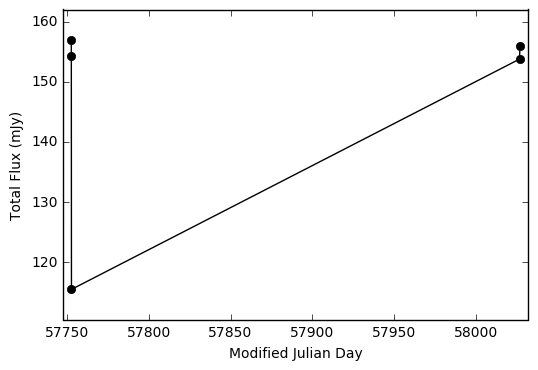

In [106]:
plt.plot(lcdf['mjdtime'], lcdf['total_flux'], '-o', c='k')
plt.xlabel('Modified Julian Day')
plt.ylabel('Total Flux (mJy)')
plt.xlim(lcdf['mjdtime'].min()-5, lcdf['mjdtime'].max()+5)
plt.ylim(lcdf['total_flux'].min()-5, lcdf['total_flux'].max()+5)

(112.503133936499, 137.54603105163301)

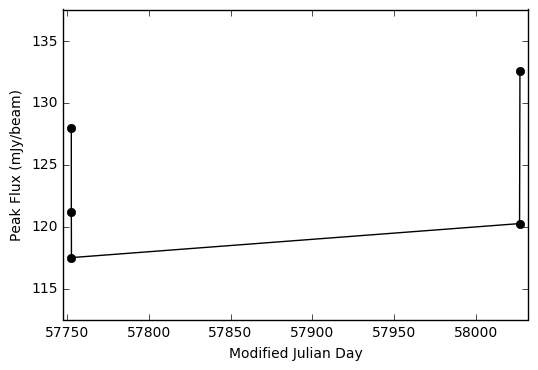

In [107]:
plt.plot(lcdf['mjdtime'], lcdf['peak_flux'], '-o', c='k')
plt.xlabel('Modified Julian Day')
plt.ylabel('Peak Flux (mJy/beam)')
plt.xlim(lcdf['mjdtime'].min()-5, lcdf['mjdtime'].max()+5)
plt.ylim(lcdf['peak_flux'].min()-5, lcdf['peak_flux'].max()+5)

This isn't super informative due to the big time gap, but it gets the point across.

Using corrected flux:

In [108]:
cur.execute('''SELECT a.src_id, a.image_id, a.total_flux, a.e_total_flux, a.peak_flux, a.e_peak_flux, 
        a.isl_rms, a.isl_mean, b.mjdtime FROM corrected_flux AS a, image AS b
        WHERE a.image_id = b.id AND (a.src_id, a.image_id) IN (
        SELECT src_id, image_id FROM detected_source WHERE assoc_id = 107)''')
cfrows = cur.fetchall()

In [109]:
for row in cfrows:
    print row

(7, 4, 337.022267970069, 41.5553841849961, 274.623195218612, 25.6233502986037, 24.5397298176853, -0.00865149150500989, 57752.6391435)
(19, 5, 331.178054250673, 28.761662962994, 260.065125462318, 17.8855261813152, 17.1015097072477, -2.04358431457741, 57752.6498842)
(4, 6, 247.938325760109, 40.5732565918547, 252.22355197813, 22.9705308026617, 23.4261045609331, -0.934010000863174, 57752.7329977)
(13, 7, 330.069808923763, 27.3238605013801, 258.122785533767, 17.0205215189708, 16.2527453067652, -2.11783232054082, 58026.7085301)
(6, 8, 333.890955869118, 49.447084547488, 283.741846168209, 30.0818481883917, 29.043517463243, -1.92643687584729, 58026.9504282)


In [110]:
cfrows.sort(key=lambda x: x[-1])
cfrows

[(7,
  4,
  337.022267970069,
  41.5553841849961,
  274.623195218612,
  25.6233502986037,
  24.5397298176853,
  -0.00865149150500989,
  57752.6391435),
 (19,
  5,
  331.178054250673,
  28.761662962994,
  260.065125462318,
  17.8855261813152,
  17.1015097072477,
  -2.04358431457741,
  57752.6498842),
 (4,
  6,
  247.938325760109,
  40.5732565918547,
  252.22355197813,
  22.9705308026617,
  23.4261045609331,
  -0.934010000863174,
  57752.7329977),
 (13,
  7,
  330.069808923763,
  27.3238605013801,
  258.122785533767,
  17.0205215189708,
  16.2527453067652,
  -2.11783232054082,
  58026.7085301),
 (6,
  8,
  333.890955869118,
  49.447084547488,
  283.741846168209,
  30.0818481883917,
  29.043517463243,
  -1.92643687584729,
  58026.9504282)]

In [111]:
tcfrows = map(list, zip(*cfrows))

In [112]:
tcfrows

[[7, 19, 4, 13, 6],
 [4, 5, 6, 7, 8],
 [337.022267970069,
  331.178054250673,
  247.938325760109,
  330.069808923763,
  333.890955869118],
 [41.5553841849961,
  28.761662962994,
  40.5732565918547,
  27.3238605013801,
  49.447084547488],
 [274.623195218612,
  260.065125462318,
  252.22355197813,
  258.122785533767,
  283.741846168209],
 [25.6233502986037,
  17.8855261813152,
  22.9705308026617,
  17.0205215189708,
  30.0818481883917],
 [24.5397298176853,
  17.1015097072477,
  23.4261045609331,
  16.2527453067652,
  29.043517463243],
 [-0.00865149150500989,
  -2.04358431457741,
  -0.934010000863174,
  -2.11783232054082,
  -1.92643687584729],
 [57752.6391435, 57752.6498842, 57752.7329977, 58026.7085301, 58026.9504282]]

In [113]:
lcdf['corr_total_flux'] = tcfrows[2]
lcdf['corr_e_total_flux'] = tcfrows[3]
lcdf['corr_peak_flux'] = tcfrows[4]
lcdf['corr_e_peak_flux'] = tcfrows[5]
lcdf['corr_isl_rms'] = tcfrows[6]
lcdf['corr_isl_mean'] = tcfrows[7]

In [114]:
lcdf

,src_id,image_id,total_flux,e_total_flux,peak_flux,e_peak_flux,maj,min,pa,mjdtime,corr_total_flux,corr_e_total_flux,corr_peak_flux,corr_e_peak_flux,corr_isl_rms,corr_isl_mean
0,7,4,157.008227,19.359365,127.938433,11.937125,9.187806,8.948904,88.546337,57752.639143,337.022268,41.555384,274.623195,25.623350,24.539730,-0.008651
2,19,5,154.285589,13.399167,121.156280,8.332312,9.208616,7.853771,98.771670,57752.649884,331.178054,28.761663,260.065125,17.885526,17.101510,-2.043584
1,4,6,115.506780,18.901822,117.503134,10.701258,12.823297,9.633942,80.117009,57752.732998,247.938326,40.573257,252.223552,22.970531,23.426105,-0.934010
3,13,7,153.769292,12.729340,120.251404,7.929333,17.896857,15.445374,104.574510,58026.708530,330.069809,27.323861,258.122786,17.020522,16.252745,-2.117832
4,6,8,155.972486,23.098513,132.546031,14.052314,16.405412,15.504223,65.883537,58026.950428,333.890956,49.447085,283.741846,30.081848,29.043517,-1.926437


In [115]:
lcdf['corr_snr'] = (lcdf['corr_peak_flux'] - lcdf['corr_isl_mean']) / lcdf['corr_isl_rms']

In [116]:
lcdf['corr_snr']

0    11.191315
2    15.326642
1    10.806644
3    16.012102
4    9.835871 
Name: corr_snr, dtype: float64

(242.938325760109, 342.02226797006898)

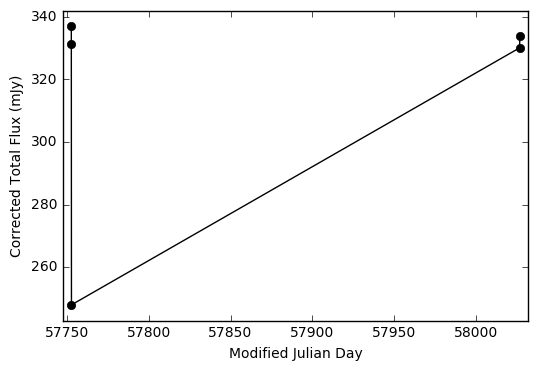

In [117]:
plt.plot(lcdf['mjdtime'], lcdf['corr_total_flux'], '-o', c='k')
plt.xlabel('Modified Julian Day')
plt.ylabel('Corrected Total Flux (mJy)')
plt.xlim(lcdf['mjdtime'].min()-5, lcdf['mjdtime'].max()+5)
plt.ylim(lcdf['corr_total_flux'].min()-5, lcdf['corr_total_flux'].max()+5)

(247.22355197812999, 288.74184616820901)

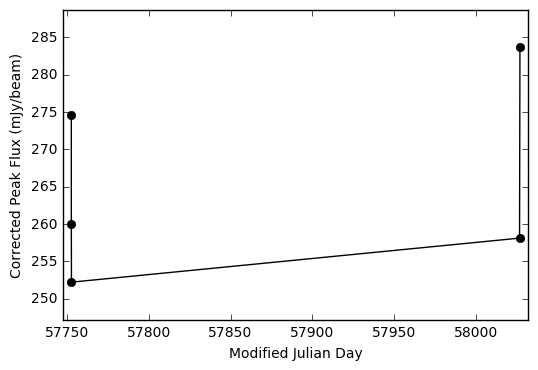

In [118]:
plt.plot(lcdf['mjdtime'], lcdf['corr_peak_flux'], '-o', c='k')
plt.xlabel('Modified Julian Day')
plt.ylabel('Corrected Peak Flux (mJy/beam)')
plt.xlim(lcdf['mjdtime'].min()-5, lcdf['mjdtime'].max()+5)
plt.ylim(lcdf['corr_peak_flux'].min()-5, lcdf['corr_peak_flux'].max()+5)

### Radio spectrum

Another thing we can do is look at a source's flux as a function of frequency. I've picked a bright source near the center of the image with 3 VLITE detections and 6 catalog matches. I'll use the VLITE measurements with the highest SNR as the flux at 340 MHz.

In [121]:
cur.execute('''SELECT a.src_id, a.image_id, a.peak_flux, b.rms, b.mean
        FROM detected_source AS a, detected_island AS b
        WHERE a.assoc_id = 11 AND (a.isl_id, a.image_id) = (b.isl_id, b.image_id)''')
snr_rows = cur.fetchall()
snr_cols = [desc[0] for desc in cur.description]
snrdf = pd.DataFrame(snr_rows, columns=snr_cols)
snrdf

,src_id,image_id,peak_flux,rms,mean
0,10,1,217.626548,30.182496,4.714074
1,11,2,190.530867,25.922570,4.998244
2,39,3,313.552133,10.902801,0.183220


In [122]:
snrdf['snr'] = (snrdf['peak_flux'] - snrdf['mean']) / snrdf['rms']

In [123]:
snrdf

,src_id,image_id,peak_flux,rms,mean,snr
0,10,1,217.626548,30.182496,4.714074,7.054171
1,11,2,190.530867,25.922570,4.998244,7.157185
2,39,3,313.552133,10.902801,0.183220,28.742057


In [124]:
cur.execute('''SELECT a.total_flux, a.e_total_flux, a.peak_flux, a.e_peak_flux, b.obs_freq
        FROM corrected_flux AS a, image AS b WHERE (a.src_id, a.image_id) = (39, 3) AND b.id = a.image_id''')
spec_rows = cur.fetchall()
spec_cols = [desc[0] for desc in cur.description]
specdf = pd.DataFrame(spec_rows, columns=spec_cols)
specdf

,total_flux,e_total_flux,peak_flux,e_peak_flux,obs_freq
0,380.674265,20.829967,348.818755,12.365449,340.85


In [125]:
specdf['catalog'] = 'VLITE'
specdf

,total_flux,e_total_flux,peak_flux,e_peak_flux,obs_freq,catalog
0,380.674265,20.829967,348.818755,12.365449,340.85,VLITE


In [126]:
cur.execute('SELECT * FROM catalog_match WHERE assoc_id = 11')
cmrows = cur.fetchall()
cmcols = [desc[0] for desc in cur.description]

In [127]:
print cmcols
for row in cmrows:
    print row

['id', 'catalog_id', 'src_id', 'assoc_id', 'min_deruiter']
(9, 2, 282927, 11, 3.3999533532866)
(42, 7, 1001610, 11, 3.73755760543861)
(88, 10, 403609, 11, 0.916515263617582)
(442, 11, 44805, 11, 4.63597591858144)
(142, 13, 122733, 11, 1.37554836180888)
(463, 12, 56749, 11, 1.47920788975528)


In [128]:
cmrows.sort(key=lambda x:x[1])
cmrows

[(9, 2, 282927, 11, 3.3999533532866),
 (42, 7, 1001610, 11, 3.73755760543861),
 (88, 10, 403609, 11, 0.916515263617582),
 (442, 11, 44805, 11, 4.63597591858144),
 (463, 12, 56749, 11, 1.47920788975528),
 (142, 13, 122733, 11, 1.37554836180888)]

In [129]:
cat_ids = zip(*cmrows)[1]
src_ids = zip(*cmrows)[2]

In [130]:
cat_ids

(2, 7, 10, 11, 12, 13)

In [131]:
cur.execute('SELECT * FROM skycat.catalogs WHERE id IN %s',
            (cat_ids, ))
skycats = cur.fetchall()
print skycats

[(2, 'first', 'VLA', 1400.0, 5.0), (7, 'nvss', 'VLA', 1400.0, 45.0), (10, 'tgss', 'GMRT', 150.0, 25.0), (11, 'txs', 'Texas Interferometer', 365.0, None), (12, 'vlssr', 'VLA', 74.0, 75.0), (13, 'wenss', 'WSRT', 325.0, 54.0)]


In [132]:
cat_srcs = zip(skycats, src_ids)
cat_srcs

[((2, 'first', 'VLA', 1400.0, 5.0), 282927),
 ((7, 'nvss', 'VLA', 1400.0, 45.0), 1001610),
 ((10, 'tgss', 'GMRT', 150.0, 25.0), 403609),
 ((11, 'txs', 'Texas Interferometer', 365.0, None), 44805),
 ((12, 'vlssr', 'VLA', 74.0, 75.0), 56749),
 ((13, 'wenss', 'WSRT', 325.0, 54.0), 122733)]

In [133]:
# src_id
cat_srcs[0][1]

282927

In [134]:
# catalog name
cat_srcs[0][0][1]

'first'

In [135]:
# catalog frequency
cat_srcs[0][0][3]

1400.0

In [136]:
for cat_src in cat_srcs:
    cat = cat_src[0][1]
    srcid = cat_src[1]
    print cat, srcid

first 282927
nvss 1001610
tgss 403609
txs 44805
vlssr 56749
wenss 122733


In [137]:
from psycopg2 import sql

In [138]:
catsrc_rows = []
for cat_src in cat_srcs:
    cat = cat_src[0][1]
    srcid = cat_src[1]
    cur.execute(psycopg2.sql.SQL('''SELECT name, total_flux, e_total_flux, peak_flux, e_peak_flux FROM skycat.{}
            WHERE id = %s''').format(psycopg2.sql.Identifier(cat)), (srcid, ))
    catsrc_rows.append(cur.fetchone())

In [139]:
catsrc_rows

[('FIRST_282927', 26.32, None, 27.16, None),
 ('NVSS_1001610', 20.7, 0.7, None, None),
 ('TGSSADR_J133321.2+303735', 654.9, 66.1, 612.2, 61.4),
 ('TXS_44805', 539.0, 48.0, None, None),
 ('VLSSr_56749', 990.0, 160.0, None, None),
 ('WENSS_122733', 423.0, 17.74, 372.0, 15.81)]

In [140]:
catdf_rows = []
for i in range(len(catsrc_rows)):
    new_row = catsrc_rows[i] + (cat_srcs[i][0][3], cat_srcs[i][0][1])
    catdf_rows.append(new_row[1:])

catdf_rows

[(26.32, None, 27.16, None, 1400.0, 'first'),
 (20.7, 0.7, None, None, 1400.0, 'nvss'),
 (654.9, 66.1, 612.2, 61.4, 150.0, 'tgss'),
 (539.0, 48.0, None, None, 365.0, 'txs'),
 (990.0, 160.0, None, None, 74.0, 'vlssr'),
 (423.0, 17.74, 372.0, 15.81, 325.0, 'wenss')]

In [141]:
catdf = pd.DataFrame(catdf_rows, columns=specdf.columns)
catdf

,total_flux,e_total_flux,peak_flux,e_peak_flux,obs_freq,catalog
0,26.32,NaN,27.16,NaN,1400.0,first
1,20.70,0.70,NaN,NaN,1400.0,nvss
2,654.90,66.10,612.20,61.40,150.0,tgss
3,539.00,48.00,NaN,NaN,365.0,txs
4,990.00,160.00,NaN,NaN,74.0,vlssr
5,423.00,17.74,372.00,15.81,325.0,wenss


In [142]:
allspecdf = specdf.append(catdf, ignore_index=True)
allspecdf

,total_flux,e_total_flux,peak_flux,e_peak_flux,obs_freq,catalog
0,380.674265,20.829967,348.818755,12.365449,340.85,VLITE
1,26.320000,NaN,27.160000,NaN,1400.00,first
2,20.700000,0.700000,NaN,NaN,1400.00,nvss
3,654.900000,66.100000,612.200000,61.400000,150.00,tgss
4,539.000000,48.000000,NaN,NaN,365.00,txs
5,990.000000,160.000000,NaN,NaN,74.00,vlssr
6,423.000000,17.740000,372.000000,15.810000,325.00,wenss


In [143]:
allspecdf.sort_values('obs_freq', inplace=True)

In [144]:
allspecdf

,total_flux,e_total_flux,peak_flux,e_peak_flux,obs_freq,catalog
5,990.000000,160.000000,NaN,NaN,74.00,vlssr
3,654.900000,66.100000,612.200000,61.400000,150.00,tgss
6,423.000000,17.740000,372.000000,15.810000,325.00,wenss
0,380.674265,20.829967,348.818755,12.365449,340.85,VLITE
4,539.000000,48.000000,NaN,NaN,365.00,txs
1,26.320000,NaN,27.160000,NaN,1400.00,first
2,20.700000,0.700000,NaN,NaN,1400.00,nvss


In [145]:
import numpy as np

In [146]:
# Plot the Perley & Butler (2017) fluxes for comparison
def PB17_flux(fMHz):
    f = fMHz / 1000.
    logSJy = 1.2481 - 0.4507*np.log10(f) - 0.1798*(np.log10(f))**2. + 0.0357*(np.log10(f))**3.
    logSmJy = logSJy + 3.
    return logSmJy

(0.0, 5.0)

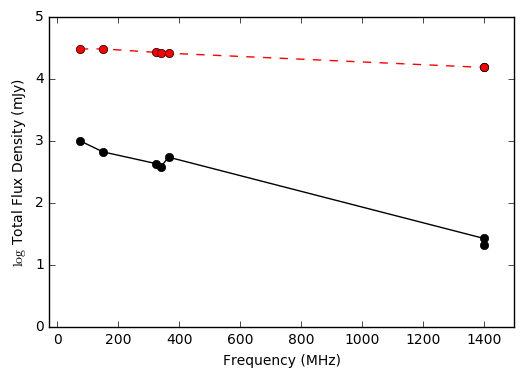

In [148]:
plt.plot(allspecdf['obs_freq'], np.log10(allspecdf['total_flux']), '-o', c='k')
plt.plot(allspecdf['obs_freq'], PB17_flux(allspecdf['obs_freq']), '--o', c='r')
plt.xlabel('Frequency (MHz)')
plt.ylabel('$\log$ Total Flux Density (mJy)')
plt.xlim(allspecdf['obs_freq'].min()-100, allspecdf['obs_freq'].max()+100)
plt.ylim(0., 5.)

The offset is probably due to the fact that the observed flux measurements are not on the Perley and Butler (2017) scale.

In [149]:
cur.close()
conn.close()